<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/transformers/LMP_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install package dependencies (forces restart)
import os

def restart_runtime():
    print('Runtime restarting...')
    os.kill(os.getpid(), 9)

%pip -q install pybullet wandb
!git clone https://github.com/sholtodouglas/pandaRL local_packages/pandaRL
%pip install -e local_packages/pandaRL/.

restart_runtime()

     |████████████████████████████████| 102.2MB 37kB/s 
     |████████████████████████████████| 1.7MB 58.0MB/s 
     |████████████████████████████████| 122kB 63.5MB/s 
     |████████████████████████████████| 102kB 13.7MB/s 
     |████████████████████████████████| 163kB 58.7MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
Cloning into 'local_packages/pandaRL'...
remote: Enumerating objects: 477, done.
remote: Counting objects: 100% (477/477), done.
remote: Compressing objects: 100% (342/342), done.
remote: Total 477 (delta 192), reused 402 (delta 121), pack-reused 0
Receiving objects: 100% (477/477), 20.97 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (192/192), done.
Obtaining file:///content/local_packages/pandaRL
  Running setup.py develop for pandaRL


In [5]:
#@title Workpace Setup (Local vs Colab)
from google.colab import drive, auth
from os.path import join
import os

COLAB = True #@param {type:"boolean"}
AUTH_GCS = False #@param {type:"boolean"}
DEVICE = "TPU" #@param ["TPU", "GPU"]
DATA_SOURCE = "Google Drive" #@param ["Google Drive", "GCS"]
DATASET = "new_ori_one_obj" #@param ["new_ori_one_obj", "one_obj_play"]
GCS_USER = "tristan" #@param ["sholto", "tristan"]
if COLAB:
    if AUTH_GCS:
        auth.authenticate_user()
        if GCS_USER == 'tristan':
          GCS_PROJECT = "learning-from-play"
          GCS_BUCKET = "colab-gcs"
        else:
          GCS_PROJECT = "learning-from-play-288601"
          GCS_BUCKET = "colab-gcs1"

        !gcloud config set project {GCS_PROJECT}
    if DATA_SOURCE == "GCS":
        ROOT = 'gs://colab-gcs'
        PROJ = 'data/one_obj_play'
        PROJECT_PATH = '/content/data'
        !mkdir /content/data
        !gsutil -m cp -r {ROOT}/{PROJ} {PROJECT_PATH}
    else:
        ROOT = '/content/drive'     # default for the drive
        PROJ = 'My Drive/Robotic Learning'       # path to your project on Drive
        PROJECT_PATH = os.path.join(ROOT, PROJ)
        drive.mount(ROOT)           # we mount the drive at /content/drive
    PYBULLET_DATA_DIR = os.path.join(PROJECT_PATH, DATASET)

    # Sync drive to VM directory
    # !rsync -aP --exclude=data/ "{PROJECT_PATH}/"  '/content/learning_from_play'
    # %cd '/content/learning_from_play'
else:
    # Todo:
    pass

Mounted at /content/drive


In [1]:
%%sh
git clone https://github.com/sholtodouglas/learning_from_play
git clone https://github.com/tfrizza/minGPT

Cloning into 'learning_from_play'...
Cloning into 'minGPT'...


In [2]:
import sys
sys.path.append("/content/minGPT")
print(sys.path)

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/content/local_packages/pandaRL', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/minGPT']


In [3]:
%cd '/content/learning_from_play'

/content/learning_from_play


In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   train.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	wandb/

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add .

In [ ]:
!git pull

remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 29 (delta 13), reused 28 (delta 13), pack-reused 0
Unpacking objects: 100% (29/29), done.
From https://github.com/sholtodouglas/learning_from_play
   99bd04e..7d425f6  master     -> origin/master
 * [new branch]      plotting   -> origin/plotting
Updating 99bd04e..7d425f6
Fast-forward
 Deploy.ipynb                           |  682 ++-
 LMP_Test.ipynb                         | 7566 ++++++++++++++++++--------------
 Use this to play the sample data.ipynb | 1532 +++++--
 data_collection/full_vr.py             |   12 +-
 test.npz                               |  Bin 0 -> 814036 bytes
 5 files changed, 5999 insertions(+), 3793 deletions(-)
 create mode 100644 test.npz


In [ ]:
#@title Git config (for commits)
email = "sholto.douglas1@gmail.com" #@param {type:"string"}
name = "sholtodouglas" #@param {type:"string"}

!git config --global user.email "{email}"
!git config --global user.name "{name}"

In [ ]:
#@title Git commit
commit_msg = "update beta scheduler" #@param {type:"string"}
!git commit -m "{commit_msg}"

[master a8b133a] update beta scheduler
 1 file changed, 1 insertion(+)


In [ ]:
#@title Git push
branch = "master" #@param ["master"] {allow-input: true}
!git push -u origin {branch}

fatal: could not read Username for 'https://github.com': No such device or address


# Data Creation

In [6]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

if DEVICE=="TPU":
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
else:
    physical_devices = tf.config.list_physical_devices()
    if DEVICE is 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.3.0
Running on TPU  ['10.31.34.50:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.31.34.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.31.34.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Dataset

In [7]:
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
from collections import Counter
import random
import datetime

import data

In [8]:
# Use this to edit modules without needing to restart the kernel
# import importlib
# importlib.reload(data)

In [9]:
RELATIVE = True # use relative joints instead of absolute pos/ori as in the original paper
QUAT = False # whether to use quaternions or rpy in actions
JOINTS = False # use relative joints instead of absolute angles
VELOCITY = True

In [10]:
def load_data(path, keys):
    dataset = {k:[] for k in keys+['sequence_index','sequence_id']}
    obs_act_path = os.path.join(path, 'obs_act_etc/')

    for demo in os.listdir(obs_act_path):
        traj = np.load(obs_act_path+demo+'/data.npz')
        for k in keys:
            dataset[k].append(traj[k].astype(np.float32))
        timesteps = len(traj['obs'])
        dataset['sequence_index'].append(np.arange(timesteps, dtype=np.int32).reshape(-1, 1))
        dataset['sequence_id'].append(np.full(timesteps, fill_value=int(demo), dtype=np.int32).reshape(-1, 1))

    # convert to numpy
    for k in keys+['sequence_index','sequence_id']:
        dataset[k] = np.vstack(dataset[k])
    return dataset

In [11]:
keys = ['obs', 'acts', 'achieved_goals', 'joint_poses', 'target_poses', 'acts_rpy', 'acts_rpy_rel',  'velocities']
dataset = load_data(PYBULLET_DATA_DIR, keys)

if JOINTS:
    OBS_DIM = dataset['obs'].shape[1] + 7 
    ACT_DIM = dataset['target_poses'].shape[1] + 1
else:
    OBS_DIM = dataset['obs'].shape[1]
    if QUAT:
        ACT_DIM = dataset['acts'].shape[1]
    else:
        ACT_DIM = dataset['acts_rpy'].shape[1]

if VELOCITY:
    OBS_DIM += dataset['velocities'].shape[1]
        
GOAL_DIM = dataset['achieved_goals'].shape[1]
print(f'Obs: (N,{OBS_DIM}), Acts: (N,{ACT_DIM}), Goals: (N,{GOAL_DIM})')

Obs: (N,25), Acts: (N,7), Goals: (N,11)


In [12]:
DATASET_SIZE = dataset['obs'].shape[0]
secs = DATASET_SIZE / 20
hours = secs // 3600
minutes = secs // 60 - hours * 60
print(f"We have {DATASET_SIZE} frames of data, which is {hours:.0f}hrs {minutes:.0f}m.")

We have 73507 frames of data, which is 1hrs 1m.


In [13]:
# Ok data aug time! # flip to the equivalent quaternion to add more data
OBS_QUATERNION_INDICES = [(3,7), (10,14)]
GOAL_QUATERNION_INDICES = [(3,7)]
for k in keys+['sequence_index','sequence_id']:
    augmented_data = dataset[k].copy()
    if k == 'obs':
        for pair in OBS_QUATERNION_INDICES:
            augmented_data[pair[0]:pair[1]]= - augmented_data[pair[0]:pair[1]]
    if k == 'achieved_goals':
        for pair in GOAL_QUATERNION_INDICES:
            augmented_data[pair[0]:pair[1]]= - augmented_data[pair[0]:pair[1]]
    
    dataset[k] = np.concatenate([augmented_data, dataset[k]], 0)

In [14]:
DATASET_SIZE = dataset['obs'].shape[0]
secs = DATASET_SIZE / 20
hours = secs // 3600
minutes = secs // 60 - hours * 60
print(f"After augmentation we have {DATASET_SIZE} frames of data, which is {hours:.0f}hrs {minutes:.0f}m.")

After augmentation we have 147014 frames of data, which is 2hrs 2m.


In [17]:
BATCH_SIZE_PER_REPLICA = 512
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_DEVICES

WINDOW_SIZE = 40
MIN_WINDOW_SIZE = WINDOW_SIZE//2
WINDOW_SHIFT = 1
SHUFFLE_SIZE = GLOBAL_BATCH_SIZE*4
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
NUM_WORKERS = 4
TRAIN_TEST_SPLIT = 0.9
VARIABLE_SEQ_LENS = True

window_lambda = lambda x: tf.data.Dataset.zip(x).batch(WINDOW_SIZE)
seq_overlap_filter = lambda x: tf.equal(tf.size(tf.unique(tf.squeeze(x['sequence_id'])).y), 1)

def create_goal_tensor(dataset, seq_len=-1):
    ''' Tile final achieved_goal across time dimension '''
    tile_dims = tf.constant([WINDOW_SIZE, 1], tf.int32)
    goal = tf.tile(dataset['achieved_goals'][seq_len-1,tf.newaxis], tile_dims) # as goal is at an index take seq_len -1
    return goal

def transform_states(dataset):
    if JOINTS:
        if RELATIVE:
          rel = dataset['target_poses'] - dataset['joint_poses'][:,:7]
        else:
          rel = dataset['target_poses']

        gripper = dataset['acts'][:,-1,tf.newaxis]
        acts = tf.concat([rel, gripper], axis=-1)
        obs = tf.concat([dataset['obs'],dataset['joint_poses'][:,:7]], axis=-1)#.astype('float32')
    else:
        obs = dataset['obs']
        if RELATIVE:
            if QUAT:
                rel = dataset['acts'][:,:7] - dataset['obs'][:,:7]
            else:
                rel = dataset['acts_rpy_rel'][:,:6]
                
            gripper = dataset['acts'][:,-1,tf.newaxis]
            acts = tf.concat([rel, gripper], axis=-1)
        else:
            if QUAT:
                acts = dataset['acts']
            else:
                acts = dataset['acts_rpy']


    if VELOCITY:
      obs = tf.concat([obs, dataset['velocities']], axis = -1)  
    
    # Variable Seq len
    if VARIABLE_SEQ_LENS:
      seq_len = tf.random.uniform(shape=[], minval=MIN_WINDOW_SIZE, maxval=WINDOW_SIZE, dtype=tf.int32, seed=10)
    else:
      seq_len = WINDOW_SIZE # SEQLENS Just at max window size

    mask = tf.cast(tf.sequence_mask(seq_len, maxlen=WINDOW_SIZE), tf.float32) # creates a B*T mask
    multiply_mask = tf.expand_dims(mask, -1)

    goals = create_goal_tensor(dataset, seq_len)

    obs = obs * multiply_mask
    acts = acts * multiply_mask
    goals = goals * multiply_mask

    return {'obs':obs, 'acts':acts, 'goals':goals, 'seq_lens': tf.cast(seq_len, tf.float32), 'masks':mask, 
           'dataset_path':dataset['sequence_id'], 'tstep_idxs':dataset['sequence_index']}

def tf_ds_transform(dataset):
    return dataset\
                .window(size=WINDOW_SIZE, shift=WINDOW_SHIFT, stride=1, drop_remainder=True)\
                .flat_map(window_lambda)\
                .filter(seq_overlap_filter)\
                .shuffle(SHUFFLE_SIZE)\
                .repeat()\
                .map(transform_states, num_parallel_calls=NUM_WORKERS)\
                .batch(GLOBAL_BATCH_SIZE, drop_remainder=True)\
                .prefetch(PREFETCH_SIZE)\
                # .cache()

# Todo: Need to confirm splitting here works with shuffle() and repeat()
train_size = int(TRAIN_TEST_SPLIT * DATASET_SIZE)

full_dataset = tf.data.Dataset.from_tensor_slices(dataset)
train_dataset = tf_ds_transform(full_dataset.take(train_size))
valid_dataset = tf_ds_transform(full_dataset.skip(train_size))
train_dataset

<PrefetchDataset shapes: {obs: (4096, 40, 25), acts: (4096, 40, 7), goals: (4096, 40, 11), seq_lens: (4096,), masks: (4096, 40), dataset_path: (4096, None, 1), tstep_idxs: (4096, None, 1)}, types: {obs: tf.float32, acts: tf.float32, goals: tf.float32, seq_lens: tf.float32, masks: tf.float32, dataset_path: tf.int32, tstep_idxs: tf.int32}>

# Model

In [18]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input, LSTM, Concatenate, Masking, Reshape, Lambda, Bidirectional, GRU
from tensorflow.keras.regularizers import l1, l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

## LSTM Model
Use this to map obs -> act

In [19]:
def create_encoder(layer_size=2048, latent_dim = 256, epsilon=1e-4, training=True):
    # Input #
    obs = Input(shape=(40, OBS_DIM), dtype=tf.float32, name='obs')
    acts = Input(shape=(40, ACT_DIM), dtype=tf.float32, name='acts') 

    # Layers #
    x = Concatenate(axis=-1)([obs, acts])
    x = Masking(mask_value=0.)(x)
    x = Bidirectional(LSTM(layer_size, return_sequences=True), merge_mode='concat')(x)
    x = Bidirectional(LSTM(layer_size, return_sequences=False), merge_mode='concat')(x)

    # Latent Variable # 
    mu = Dense(latent_dim, activation=None, name='mu')(x)
    scale = Dense(latent_dim, activation="softplus", name='sigma')(x + epsilon)
    
    mixture = tfpl.DistributionLambda(latent_normal, name='latent_variable')((mu, scale))
    return Model([obs, acts], mixture)


def create_planner(layer_size=2048, latent_dim = 256, epsilon=1e-4, training=True):
    # params #
    batch_size = None

    # Input #
    o_i = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    o_g = Input(shape=(GOAL_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o_i, o_g])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    x = Dense(layer_size, activation="relu", name='layer_4')(x)

    # Latent Variable # 
    mu = Dense(latent_dim, activation=None, name='mu')(x)
    scale = Dense(latent_dim, activation="softplus", name='sigma')(x + epsilon)
    
    mixture = tfpl.DistributionLambda(latent_normal,  name='latent_variable')((mu, scale))
    return Model([o_i, o_g], mixture)

def create_actor(layer_size=1024, latent_dim = 256, epsilon=1e-4, num_distribs=None, GCBC=False, training=True):
    # params #
    batch_size = None if training else 1
    stateful = not training

    # Input #
    o = Input(shape=(None, OBS_DIM), batch_size=batch_size, dtype=tf.float32, name='input_obs')
    z = Input(shape=(None, latent_dim), batch_size=batch_size, dtype=tf.float32, name='input_latent')
    g = Input(shape=(None, GOAL_DIM), batch_size=batch_size, dtype=tf.float32, name='input_goals')

    # RNN #
    if GCBC:      
      x =  Concatenate(axis=-1)([o,g])
    else:
      x =  Concatenate(axis=-1)([o,z,g])

    x = Masking(mask_value=0.)(x)
    x = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1')(x)
    x = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2')(x)

    # Probabilistic Mixture Model #
    if num_distribs:
        weightings = Dense(ACT_DIM*num_distribs, activation=None, name='alpha')(x)
        mu = Dense(ACT_DIM*num_distribs, activation=None, name='mu')(x)
        scale = Dense(ACT_DIM*num_distribs, activation="softplus", name='sigma')(x + epsilon)

        weightings = Reshape((-1, ACT_DIM, num_distribs))(weightings)
        mu = Reshape((-1, ACT_DIM, num_distribs))(mu)
        scale = Reshape((-1, ACT_DIM, num_distribs))(scale)
        
        actions = tfpl.DistributionLambda(logistic_mixture, name='logistic_mix')([weightings, mu, scale])
    else:
        actions = Dense(ACT_DIM, activation=None, name='acts')(x)

    if GCBC:
      return Model([o, g], actions)
    else:
      return Model([o, z, g], actions)


def latent_normal(inputs):
    mu, scale = inputs
    dist = tfd.Normal(loc=mu, scale=scale)
    return dist

def logistic_mixture(inputs):
    weightings, mu, scale = inputs
    dist = tfd.Logistic(loc=mu, scale=scale)
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=weightings),
        components_distribution=dist,
        validate_args=True
    )
    return mixture_dist

In [25]:
import math
import logging
import pdb

import numpy as np
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, Embedding, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import count_params
# import tensorflow_addons as tfa
# from tensorflow_addons.optimizers import AdamW
# from tensorflow_addons.layers import GELU

logger = logging.getLogger(__name__)

class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9 # (at what point we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, block_size, **kwargs):
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    n_embd = 768
    
def gelu(x):
    """Gaussian Error Linear Unit.
    This is a smoother version of the RELU.
    Original paper: https://arxiv.org/abs/1606.08415
    Args:
        x: float Tensor to perform activation.
    Returns:
        `x` with the GELU activation applied.
    """
    cdf = 0.5 * (1.0 + tf.tanh(
        (math.sqrt(2 / math.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

GeLU = tf.keras.activations.get(gelu)

class CausalSelfAttention(K.layers.Layer):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = Dense(config.n_embd, name='key', kernel_initializer='he_normal', bias_initializer='zeros')
        self.query = Dense(config.n_embd, name='query', kernel_initializer='he_normal', bias_initializer='zeros')
        self.value = Dense(config.n_embd, name='value', kernel_initializer='he_normal', bias_initializer='zeros')
        # regularization
        self.attn_drop = Dropout(config.attn_pdrop)
        self.resid_drop = Dropout(config.resid_pdrop)
        # output projection
        self.proj = Dense(config.n_embd, name='projection', kernel_initializer='he_normal', bias_initializer='zeros')
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.mask = 1 - tf.linalg.band_part(tf.ones((config.block_size, config.block_size)), -1, 0)#[tf.newaxis, tf.newaxis] # tf tril equivalent
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.depth = config.n_embd // config.n_head

    def split_heads(self, x, batch_size):
        """ Split the last dimension into (n_head, depth) """
        x = tf.reshape(x, (batch_size, -1, self.n_head, self.depth))    # (B, T, ne) -> (B, T, nh, d)
        return tf.transpose(x, perm=[0, 2, 1, 3])    # (B, nh, T, d)
    
    def reassemble_heads(self, x, batch_size):
        """ Concat the last two dimensions into (n_embd,) - inverse transform of `split_heads()` """
        x = tf.transpose(x, perm=[0, 2, 1, 3])    # (B, nh, T, d)
        return tf.reshape(x, (batch_size, -1, self.n_embd))    # (B, T, ne)
    
    def scaled_dot_product_attention(self, q, k, v, mask, training=True):
        """ Calculate the attention weights v(q*k) 
        q*k gives relevance measure - better matched a k is to q, the higher it will activate and thus will feature more in the v output
        """
        matmul_qk = tf.matmul(q, k, transpose_b=True)    # (..., T, T)

        # scale matmul_qk
        dk = tf.cast(k.shape[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # add the mask to the scaled tensor.
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)    

        # softmax is normalized on the last axis (T) so that the scores
        # add up to 1.
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)    # (..., T, T)
        attention_weights = self.attn_drop(attention_weights, training=training)

        # (B, nh, T, T) x (B, nh, T, d) -> (B, nh, T, d)
        output = tf.matmul(attention_weights, v)    # (..., T, d)

        return output, attention_weights
        
    def call(self, x, training=True):
        B = tf.shape(x)[0]
        T = tf.shape(x)[1]

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # n_embd = n_heads * depth
        k = self.key(x)    # (B, T, ne)
        q = self.query(x)    # (B, T, ne)
        v = self.value(x)    # (B, T, ne)
        
        k = self.split_heads(k, B)    # (B, nh, T, d)
        q = self.split_heads(q, B)    # (B, nh, T, d)
        v = self.split_heads(v, B)    # (B, nh, T, d)

        # causal self-attention; Self-attend: (B, nh, T, d) x (B, nh, d, T)
        y, w = self.scaled_dot_product_attention(q, k, v, self.mask[:T,:T], training=training)    # (B, nh, T, d), (B, nh, T, T)
        y = self.reassemble_heads(y, B) # re-assemble all head outputs side by side (B, T, ne)

        # output projection
        y = self.resid_drop(self.proj(y), training=training)    # (B, T, ne)
        return y

class Block(K.layers.Layer):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNormalization()
        self.ln2 = LayerNormalization()
        self.attn = CausalSelfAttention(config)
        self.mlp = K.Sequential([
            Dense(4 * config.n_embd, activation=GeLU, kernel_initializer='he_normal', bias_initializer='zeros'),
            Dense(config.n_embd, kernel_initializer='he_normal', bias_initializer='zeros'),
            Dropout(config.resid_pdrop),
        ])

    def call(self, x, training=True):
        x = x + self.attn(self.ln1(x), training=training)
        x = x + self.mlp(self.ln2(x), training=training)
        return x

class GPT(K.Model):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config, train_config):
        super().__init__()

        self.pos_emb = self.add_weight("position_embedding",
                                       shape=(1, config.block_size, config.n_embd),
                                       initializer='zeros',
                                       dtype=tf.float32)
        self.drop = Dropout(config.embd_pdrop)
        # transformer
        self.blocks = K.Sequential([Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = LayerNormalization()
        self.head = Dense(ACT_DIM, use_bias=False, kernel_initializer='he_normal')

        self.block_size = config.block_size
        # self.apply(self._init_weights)
        self.loss_fn = K.losses.CategoricalCrossentropy(from_logits=True)#K.losses.SparseCategoricalCrossentropy(from_logits=True)

        # self.optimizer = Adam()#self.configure_optimizers(train_config)
        # self.compile(optimizer=self.optimizer,
        #               loss=self.loss_fn,
        #               metrics=['accuracy'])
#         self.build(input_shape=(None, config.block_size))
#         logger.info("number of parameters: %e", np.sum([K.count_params(w) for w in self.trainable_weights]))
        
    def get_block_size(self):
        return self.block_size

    # def configure_optimizers(self, train_config):
    #     """
    #     This long function is unfortunately doing something very simple and is being very defensive:
    #     We are separating out all parameters of the model into two buckets: those that will experience
    #     weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
    #     We are then returning the PyTorch optimizer object.
    #     """
    #     # Todo: We weight decay all params whereas Karpathy excludes biases, LN, embeddings
    #     optimizer = AdamW(weight_decay=train_config.weight_decay, lr=train_config.learning_rate,
    #                       beta_1=train_config.betas[0], beta_2=train_config.betas[1])
    #     return optimizer

#     @tf.function
    def call(self, inputs: tf.Tensor, training=True):
        o, g = inputs
        B, T, D = o.shape
        assert T <= self.block_size, "Cannot forward, model block size is exhausted."

        inputs = Concatenate(axis=-1)(inputs)

        # forward the GPT model
        position_embeddings = self.pos_emb[:, :T, :] # each position maps to a (learnable) vector
        x = self.drop(inputs + position_embeddings, training=training)
        x = self.blocks(x, training=training)
        x = self.ln_f(x)
        logits = self.head(x)
        
        return logits

In [21]:
x = next(iter(train_dataset))

In [22]:
# from mingpt_tf.model import GPT, GPTConfig, TrainerConfig

mconf = GPTConfig(block_size=WINDOW_SIZE,
                  n_layer=4, n_head=3, n_embd=OBS_DIM+GOAL_DIM)
tconf = TrainerConfig()
actor = GPT(mconf, tconf)

In [23]:
actor([x['obs'], x['goals']])

<tf.Tensor: shape=(4096, 40, 7), dtype=float32, numpy=
array([[[-2.24742   ,  1.9904671 ,  1.1779385 , ..., -0.6460666 ,
          0.49068037,  0.92728466],
        [-0.8003782 ,  1.1418939 ,  2.280162  , ..., -1.707825  ,
          1.2402183 ,  1.7963899 ],
        [-0.88105416,  1.5778642 ,  0.5453658 , ..., -2.373343  ,
          0.23298392,  0.49603516],
        ...,
        [-2.1192665 ,  0.8461238 ,  2.0635066 , ..., -2.5291173 ,
          0.94242895, -0.3240843 ],
        [-1.0921768 ,  0.97685564,  2.3848464 , ..., -2.39972   ,
          1.725561  ,  1.2535775 ],
        [-1.1747624 ,  0.53490394,  2.738657  , ..., -1.1564837 ,
          1.264766  ,  0.6708467 ]],

       [[-3.6427355 ,  1.9414588 ,  1.502251  , ..., -0.7340138 ,
          1.3225825 , -1.1286011 ],
        [-1.5915931 ,  1.5747175 ,  1.7189045 , ...,  0.8977353 ,
          1.4144161 , -1.1574662 ],
        [-2.0028133 ,  1.9982394 ,  2.629979  , ..., -1.4381883 ,
          1.9202967 ,  0.278088  ],
        ...,

In [24]:
actor.summary()

Model: "gpt"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            multiple                  0         
_________________________________________________________________
sequential_4 (Sequential)    (4096, 40, 36)            64080     
_________________________________________________________________
layer_normalization_8 (Layer multiple                  72        
_________________________________________________________________
dense_8 (Dense)              multiple                  252       
Total params: 65,844
Trainable params: 65,844
Non-trainable params: 0
_________________________________________________________________


# Training Loop

In [26]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar
import tensorflow_addons as tfa

import time
import io
import wandb
wandb.login()
#%load_ext tensorboard

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [27]:
# Explore regularising the encoder using info-VAE, while concurrently making the planner chase it
# Add latent space projection plots

In [28]:
import umap
reducer = umap.UMAP(metric='cosine', random_state=42)

def project_latents(reducer, z_enc, z_plan):
    ''' Todo: may need to rethink vector averaging here... '''
    reducer.fit(z_enc)
    z_enc_embed = reducer.transform(z_enc)
    z_plan_embed = reducer.transform(z_plan)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(z_enc_embed[:, 0], z_enc_embed[:, 1], s=5, label='z_enc')
    ax.scatter(z_plan_embed[:, 0], z_plan_embed[:, 1], s=5, label='z_plan')
    ax.set_aspect('equal', 'datalim')
    ax.legend(loc='upper left')
    plt.axis('off')
    plt.tight_layout()
    return fig

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

In [29]:
class MaxMetric(tf.keras.metrics.Metric):

  def __init__(self, name='max_metric', **kwargs):
    super(MaxMetric, self).__init__(name=name, **kwargs)
    self.max = self.add_weight(name='max', initializer='zeros')
    self.abs_err = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)

  def update_state(self, y_true, y_pred, mask=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    values = self.abs_err(y_true, y_pred) * mask
    values = tf.cast(values, self.dtype)
    max = tf.reduce_max(values)
    if tf.math.greater(max, self.max):
        self.max.assign(max)

  def result(self):
    return self.max

In [30]:
LAYER_SIZE = 2048
LATENT_DIM = LAYER_SIZE//8
GRIPPER_WEIGHT = 1.0
GCBC = True
PROBABILISTIC = False

with strategy.scope():
  nll_action_loss = lambda y, p_y: tf.reduce_sum(-p_y.log_prob(y), axis=2)
  mae_action_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)

  def compute_loss(labels, predictions, mask, seq_lens, weightings=None):
      # Scale gripper loss
    #   if weightings:
    #     assert len(weightings)==labels.shape[-1]
    #     labels = tf.multiply(labels, weightings)
    #     predictions = tf.multiply(predictions, weightings)
      
      if PROBABILISTIC:
        per_example_loss = nll_action_loss(labels, predictions) * mask
      else:
        per_example_loss = mae_action_loss(labels, predictions) * mask

      per_example_loss = tf.reduce_sum(per_example_loss, axis = 1) / seq_lens # take mean along the timestep
      return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def compute_MAE(labels, predictions, mask, seq_lens, weightings=None):
      per_example_loss = mae_action_loss(labels, predictions) * mask
      per_example_loss = tf.reduce_sum(per_example_loss, axis = 1) / seq_lens # take mean along the timestep
      return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def compute_regularisation_loss(plan, encoding):
      # Reverse KL(enc|plan): we want planner to map to encoder (weighted by encoder)
      reg_loss = tfd.kl_divergence(encoding, plan) #+ KL(plan, encoding)
      return tf.nn.compute_average_loss(reg_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  valid_loss = tf.keras.metrics.Mean(name='valid_loss')

  train_act_with_enc_loss = tf.keras.metrics.Mean(name='train_act_with_enc_loss')
  train_act_with_plan_loss = tf.keras.metrics.Mean(name='train_act_with_plan_loss')
  valid_act_with_enc_loss = tf.keras.metrics.Mean(name='valid_act_with_enc_loss')
  valid_act_with_plan_loss = tf.keras.metrics.Mean(name='valid_act_with_plan_loss')

  train_reg_loss = tf.keras.metrics.Mean(name='reg_loss')
  valid_reg_loss = tf.keras.metrics.Mean(name='valid_reg_loss')

  valid_position_loss = tf.keras.metrics.Mean(name='valid_position_loss')
  valid_max_position_loss = MaxMetric(name='valid_max_position_loss')
  valid_rotation_loss = tf.keras.metrics.Mean(name='valid_rotation_loss')
  valid_max_rotation_loss = MaxMetric(name='valid_max_rotation_loss')
  valid_gripper_loss = tf.keras.metrics.Mean(name='valid_rotation_loss')
  
#   model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM}
#   if PROBABILISTIC:
#     actor = create_actor(**model_params, GCBC=GCBC, num_distribs=3)
#   else:
#     actor = create_actor(**model_params, GCBC=GCBC)
#     encoder = create_encoder(**model_params)
#     planner = create_planner(**model_params)
  actor = GPT(mconf, tconf)

  optimizer = tfa.optimizers.AdamW(weight_decay=1e-4, learning_rate=2e-4)
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=actor)

# Now outside strategy .scope
def train_step(inputs, beta):
  with tf.GradientTape() as tape:
    # Todo: figure out mask and seq_lens for new dataset 
    states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], inputs['masks']
    action_weights = (ACT_DIM-1)*[1.0] + [GRIPPER_WEIGHT] # 1 for all but gripper
    if GCBC:
      distrib = actor([states, goals])
      loss = compute_loss(actions, distrib, mask, seq_lens, weightings=action_weights)
      gradients = tape.gradient(loss, actor.trainable_variables)
      optimizer.apply_gradients(zip(gradients, actor.trainable_variables))
    else:
      encoding = encoder([states, actions])
      plan = planner([states[:, 0, :], goals[:, 0, :]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
      z_enc = encoding.sample()
      z_plan = plan.sample()
      z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, WINDOW_SIZE, 1))
      z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, WINDOW_SIZE, 1))

      enc_policy = actor([states, z_enc_tiled, goals])
      plan_policy = actor([states, z_plan_tiled, goals])

      act_enc_loss = compute_loss(actions, enc_policy, mask, seq_lens, weightings=action_weights)
      act_plan_loss = compute_loss(actions, plan_policy, mask, seq_lens, weightings=action_weights)
      act_loss = act_enc_loss
      reg_loss = compute_regularisation_loss(plan, encoding)
      train_act_with_enc_loss.update_state(act_enc_loss)
      train_act_with_plan_loss.update_state(act_plan_loss)
      train_reg_loss.update_state(reg_loss)
      loss = act_loss + reg_loss * beta  
      gradients = tape.gradient(loss, actor.trainable_variables+encoder.trainable_variables+planner.trainable_variables)
      optimizer.apply_gradients(zip(gradients, actor.trainable_variables+encoder.trainable_variables+planner.trainable_variables))

  train_loss.update_state(loss)
  
  return loss

def test_step(inputs, beta):
  states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], inputs['masks']
  action_weights = (ACT_DIM-1)*[1.0] + [GRIPPER_WEIGHT] # 1 for all but gripper
  if QUAT:
    # xyz, q1-4, grip
    action_breakdown = [3,4,1]
  else:
    action_breakdown = [3,3,1]

  if GCBC:
    policy = actor([states, goals])
    loss = compute_loss(actions, policy, mask, seq_lens, weightings=action_weights)
    if PROBABILISTIC:
      pos_acts, rot_acts, grip_act = tf.split(policy.sample(), action_breakdown, -1)
    else:
      pos_acts, rot_acts, grip_act = tf.split(policy, action_breakdown, -1)
  else:  
    encoding = encoder([states, actions])
    plan = planner([states[:, 0, :], goals[:, 0, :]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
    z_enc = encoding.sample()
    z_plan = plan.sample()
    z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, WINDOW_SIZE, 1))
    z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, WINDOW_SIZE, 1))

    enc_policy = actor([states, z_enc_tiled, goals])
    plan_policy = actor([states, z_plan_tiled, goals])

    act_enc_loss = compute_loss(actions, enc_policy, mask, seq_lens, weightings=action_weights)
    act_plan_loss = compute_loss(actions, plan_policy, mask, seq_lens, weightings=action_weights)
    act_loss = act_plan_loss
    reg_loss = compute_regularisation_loss(plan, encoding)
    valid_act_with_enc_loss.update_state(act_enc_loss)
    valid_act_with_plan_loss.update_state(act_plan_loss)
    valid_reg_loss.update_state(reg_loss)

    # pos, rot, gripper individual losses
    if PROBABILISTIC:
      pos_acts, rot_acts, grip_act = tf.split(plan_policy.sample(), action_breakdown, -1)
    else:
      pos_acts, rot_acts, grip_act = tf.split(plan_policy, action_breakdown, -1)
    
    loss = act_loss + reg_loss * beta

  true_pos_acts, true_rot_acts, true_grip_act = tf.split(actions, action_breakdown, -1)
  valid_position_loss.update_state(compute_MAE(true_pos_acts, pos_acts, mask, seq_lens))
  valid_max_position_loss(true_pos_acts, pos_acts, mask)
  valid_rotation_loss.update_state(compute_MAE(true_rot_acts, rot_acts, mask, seq_lens))
  valid_max_rotation_loss(true_rot_acts, rot_acts, mask)
  valid_gripper_loss.update_state(compute_MAE(true_grip_act, grip_act, mask, seq_lens))
  valid_loss.update_state(loss)

  if GCBC:
    return loss
  else:
    return loss, z_enc, z_plan

@tf.function
def distributed_train_step(dataset_inputs, beta):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs, beta))
  return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)

@tf.function
def distributed_test_step(dataset_inputs, beta):
  if GCBC:
    per_replica_losses = strategy.run(test_step, args=(dataset_inputs, beta))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
  else:
    per_replica_losses, ze, zp = strategy.run(test_step, args=(dataset_inputs, beta))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None), ze.values[0], zp.values[0]

In [31]:
train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))

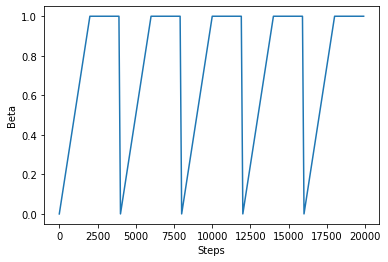

In [32]:
from train import BetaScheduler

TRAIN_STEPS = 20000

beta_sched = BetaScheduler('cyclic', 
                           beta=0, 
                           beta_max=1.0, 
                           max_steps=TRAIN_STEPS, 
                           cycles=5, 
                           duty_cycle=0.5
                           )

In [33]:
def save_weights(path):
    os.makedirs(path, exist_ok=True)

    print('Saving model weights...')
    actor.save_weights(path + 'model.h5')
    if not GCBC:
        planner.save_weights(path + 'planner.h5')
        encoder.save_weights(path + 'encoder.h5')
    print('Weights saved!')

In [34]:
progbar = Progbar(TRAIN_STEPS, verbose=1, interval=0.5)
best_valid_loss = np.float('inf')

valid_inc = 20
save_inc = 1000
t = 0

train_loss_result = []
train_act_with_enc_loss_result = []
train_act_with_plan_loss_result = []
train_reg_loss_result = []
valid_loss_result = []
valid_act_with_enc_loss_result = []
valid_act_with_plan_loss_result = []
valid_reg_loss_result = []
valid_position_loss_result = []
valid_max_position_loss_result = []
valid_rotation_loss_result = []
valid_max_rotation_loss_result = []
valid_gripper_loss_result = []
beta_result = []
latent_img_result = []

# WandB
wandb.init(project="learning-from-play")

config = wandb.config

# Hparams
config.DEVICE = DEVICE
config.BATCH_SIZE_PER_REPLICA = BATCH_SIZE_PER_REPLICA
config.WINDOW_SIZE = WINDOW_SIZE
config.WINDOW_SHIFT = WINDOW_SHIFT
config.SHUFFLE_SIZE = SHUFFLE_SIZE
config.PREFETCH_SIZE = PREFETCH_SIZE
config.NUM_WORKERS = NUM_WORKERS
config.TRAIN_TEST_SPLIT = TRAIN_TEST_SPLIT
config.LAYER_SIZE = LAYER_SIZE
config.LATENT_DIM = LATENT_DIM
config.GRIPPER_WEIGHT = GRIPPER_WEIGHT
config.TRAIN_STEPS = TRAIN_STEPS
config.beta_schedule = beta_sched.schedule
config.beta_min = beta_sched.beta_min
config.beta_max = beta_sched.beta_max

wandb: Currently logged in as: tfrizza (use `wandb login --relogin` to force relogin)


In [35]:
wandb.run.name ="GCBC_GPT"

model_name = wandb.run.name
model_path = f'/content/drive/My Drive/Robotic Learning/LMP_test/{model_name}/'

In [ ]:
while t < TRAIN_STEPS:
    beta = beta_sched.scheduler(t)
    x = next(train_dist_dataset)
    total_train_loss = distributed_train_step(x, beta)
    
    if t % valid_inc == 0:
        valid_x = next(valid_dist_dataset)
        if GCBC:
          total_val_loss = distributed_test_step(valid_x, beta)
        else:
          total_val_loss, ze, zp = distributed_test_step(valid_x, beta)

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', train_loss.result()), ('Validation Loss', valid_loss.result())])

        train_loss_result.append(train_loss.result())
        valid_loss_result.append(valid_loss.result())
        valid_position_loss_result.append(valid_position_loss.result())
        valid_max_position_loss_result.append(valid_max_position_loss.result())
        valid_rotation_loss_result.append(valid_rotation_loss.result())
        valid_max_rotation_loss_result.append(valid_max_rotation_loss.result())
        valid_gripper_loss_result.append(valid_gripper_loss.result())

        if GCBC:
          wandb.log({'train_loss_result':train_loss_result[-1],
                      'valid_loss_result':valid_loss_result[-1],
                      'valid_position_loss_result':valid_position_loss_result[-1],
                      'valid_max_position_loss_result':valid_max_position_loss_result[-1],
                      'valid_rotation_loss_result':valid_rotation_loss_result[-1],
                      'valid_max_rotation_loss_result':valid_max_rotation_loss_result[-1],
                      'valid_gripper_loss_result':valid_gripper_loss_result[-1]
                    },
                    step=t)
        else:
                    # Latent space projection
          latent_fig = project_latents(reducer, ze, zp)
          latent_img = plot_to_image(latent_fig)
          train_act_with_enc_loss_result.append(train_act_with_enc_loss.result())
          train_act_with_plan_loss_result.append(train_act_with_plan_loss.result())
          train_reg_loss_result.append(train_reg_loss.result())
          valid_act_with_enc_loss_result.append(valid_act_with_enc_loss.result())
          valid_act_with_plan_loss_result.append(valid_act_with_plan_loss.result())
          valid_reg_loss_result.append(valid_reg_loss.result())
          beta_result.append(beta)
          latent_img_result.append(latent_img)

          wandb.log({'train_loss_result':train_loss_result[-1],
                      'train_act_with_enc_loss_result':train_act_with_enc_loss_result[-1],
                      'train_act_with_plan_loss_result':train_act_with_plan_loss_result[-1],
                      'train_reg_loss_result':train_reg_loss_result[-1],
                      'valid_loss_result':valid_loss_result[-1],
                      'valid_act_with_enc_loss_result':valid_act_with_enc_loss_result[-1],
                      'valid_act_with_plan_loss_result':valid_act_with_plan_loss_result[-1],
                      'valid_reg_loss_result':valid_reg_loss_result[-1],
                      'valid_position_loss_result':valid_position_loss_result[-1],
                      'valid_max_position_loss_result':valid_max_position_loss_result[-1],
                      'valid_rotation_loss_result':valid_rotation_loss_result[-1],
                      'valid_max_rotation_loss_result':valid_max_rotation_loss_result[-1],
                      'valid_gripper_loss_result':valid_gripper_loss_result[-1],
                      'beta_result':beta_result[-1],
                      'latent_img_result':latent_fig,
                    },
                    step=t)

        # reset metrics
        train_loss.reset_states()
        train_act_with_enc_loss.reset_states()
        train_act_with_plan_loss.reset_states()
        train_reg_loss.reset_states()
        valid_loss.reset_states()
        valid_act_with_enc_loss.reset_states()
        valid_act_with_plan_loss.reset_states()
        valid_reg_loss.reset_states()

        valid_position_loss.reset_states()
        valid_max_position_loss.reset_states()
        valid_rotation_loss.reset_states()
        valid_max_rotation_loss.reset_states()
        valid_gripper_loss.reset_states()

    if t % save_inc == 0:
        save_weights(model_path)

    t += 1

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   20/20000 [..............................] - ETA: 10:22:29 - Train Loss: 0.1458 - Validation Loss: 0.1396Saving model weights...
Weights saved!
 1020/20000 [>.............................] - ETA: 9:35:31 - Train Loss: 0.0244 - Validation Loss: 0.0231Saving model weights...
Weights saved!
 1080/20000 [>.............................] - ETA: 9:34:21 - Train Loss: 0.0237 - Validation Loss: 0.0225

In [27]:
save_weights(model_path)

Saving model weights...
Weights saved!


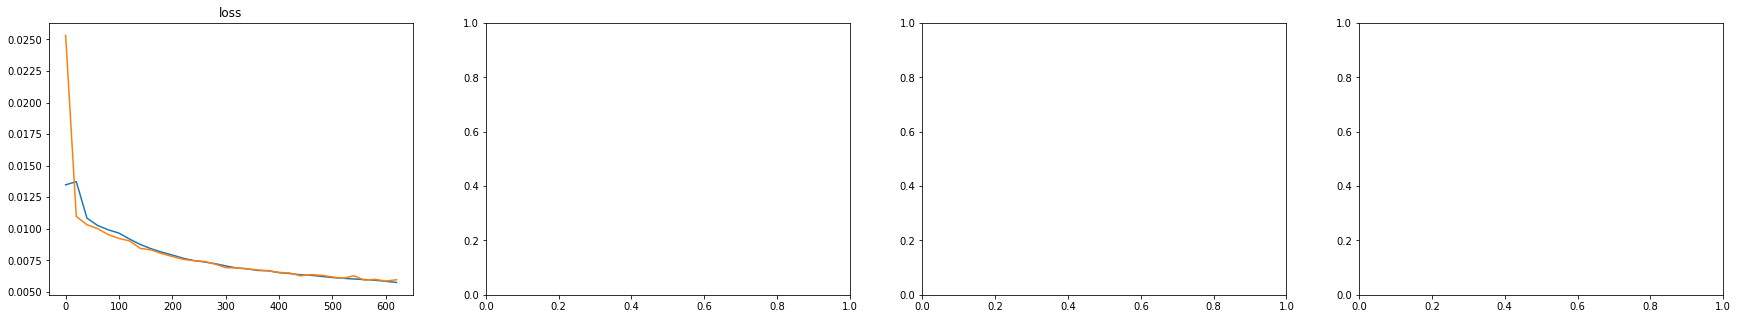

In [28]:
#@title Broke man's Tensorboard
s = np.arange(t, step=valid_inc)

# hparams/
if not GCBC:
  f1,ax1 = plt.subplots(1,1, figsize=(6,5))
  ax1.plot(s, beta_result, label='beta')
  ax1.set_title('beta')

# losses/
f2,ax2 = plt.subplots(1,4, figsize=(30,5))
ax2[0].plot(s, train_loss_result, label='train')
ax2[0].plot(s, valid_loss_result, label='valid')
ax2[0].set_title('loss')
#ax2[0].set_ylim(0,1e-3)
if not GCBC:
  ax2[1].plot(s, train_act_with_enc_loss_result, label='train')
  ax2[1].plot(s, valid_act_with_enc_loss_result, label='valid')
  ax2[1].set_title('act_with_enc_loss')
  ax2[1].set_ylim(0,5e-4)
  ax2[2].plot(s, train_act_with_plan_loss_result, label='train')
  ax2[2].plot(s, valid_act_with_plan_loss_result, label='valid')
  ax2[2].set_title('act_with_plan_loss')
  ax2[2].set_ylim(0,7e-4)
  ax2[3].plot(s, train_reg_loss_result, label='train')
  ax2[3].plot(s, valid_reg_loss_result, label='valid')
  ax2[3].set_title('reg_loss')
  [ax.legend() for ax in ax2]
# [ax.set_yscale('log') for ax in ax2]

  # images/
  f3,ax3 = plt.subplots(1,1, figsize=(6,5))
  ax3.imshow(latent_img_result[-1].numpy()[0], label='latent_img_result')
  ax3.set_title('Latent space projection')

  plt.show()

In [ ]:
# %tensorboard --logdir {tb_base_dir}

In [29]:
#@title Sample a batch for timeseries plotting
# Lets plot pred actions vs true actions
v_it = iter(valid_dataset.repeat())
batch = v_it.next()
states,acts,goals,seq_lens,masks = batch['obs'],batch['acts'],batch['goals'],batch['seq_lens'],batch['masks']
if GCBC:
  pred_acts = actor([states, goals])
else:
  encoding = encoder([states,acts])
  plan = planner([states[:, 0, :], goals[:, 0, :]]) # TODO this is really aggravating, if we have variable sequence lengths we need to pass
                                                        # Through the indices of the final index, can't just use the last 1, unless we copy it out instead of tiling?
  # check if encoder is overfitting on validation
  z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, WINDOW_SIZE, 1))
  enc_act_distrib = actor([states, z_enc, goals])

  # true validation performance, w/ planner
  z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, WINDOW_SIZE, 1))
  pred_acts = actor([states, z, goals]) # TODO Check can you backprop through samples

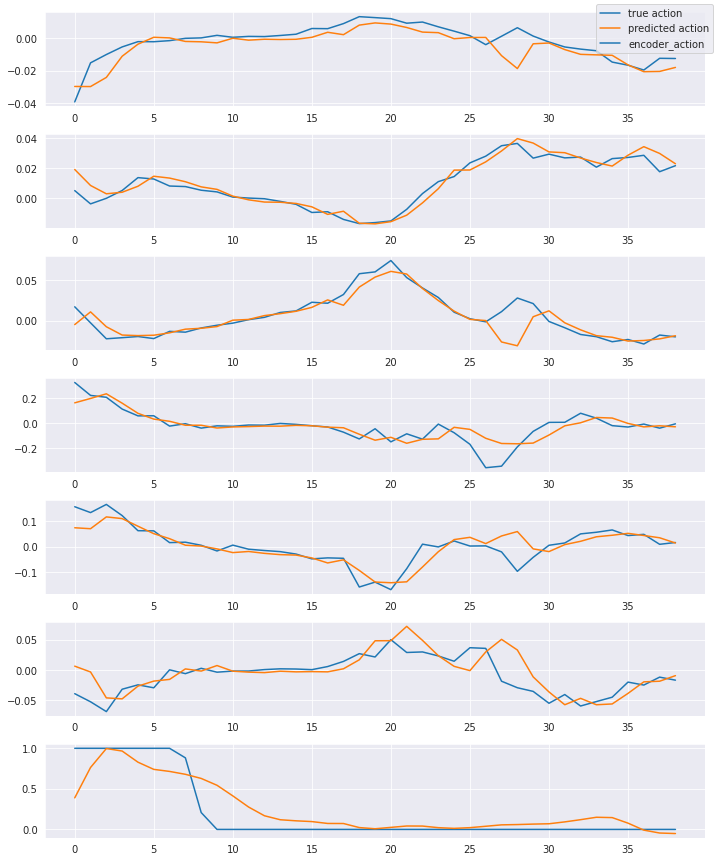

In [30]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
import seaborn as sns
sns.set_style("darkgrid")

idx = 12
seq_len = int(seq_lens[idx])
x = np.arange(seq_len)
labels = ['x','y','z','q1','q2','q3','q4','gripper']
fig, axes = plt.subplots(ACT_DIM, 1, figsize=(10,12), squeeze=True)
for i in range(ACT_DIM):
    #sns.lineplot(x, acts[idx,:seq_len,i], color='r', ax=axes[i])
    axes[i].plot(acts[idx,:seq_len,i])
    axes[i].plot(pred_acts[idx, :seq_len,i])
    #sns.lineplot(x, pred_acts[idx, :seq_len,i], color='g', ax=axes[i])
    if not GCBC:
      sns.lineplot(x, enc_act_distrib[idx, :seq_len,i], color='b', ax=axes[i])
      axes[i].set_title(f'$\\bf{labels[i]}$')
    
fig.legend( ('true action', 'predicted action', 'encoder_action'))    
plt.tight_layout()
plt.show()

#Eval

In [ ]:
# path = 'GCBCBoi'
# if GCBC:
#     actor.load_weights(f'saved_models/{path}/model.h5')
# else:
#     encoder.load_weights(f'saved_models/{path}/encoder.h5')
#     planner.load_weights(f'saved_models/{path}/planner.h5')

In [31]:
import time
import pandaRL
import gym
import matplotlib.pyplot as plt 
from IPython.display import display, clear_output
import imageio
import eval
if JOINTS and RELATIVE:
    env = gym.make('pandaPlayRelJoints1Obj-v0')
elif JOINTS and not RELATIVE:
    env = gym.make('pandaPlayAbsJoints1Obj-v0')
    #env = gym.make('pandaPlayJoints-v0')
elif not JOINTS and RELATIVE:
    env = gym.make('pandaPlayRel1Obj-v0')
else:
    env = gym.make('pandaPlay1Obj-v0')

env.reset()
env.render('playback')

current_dir=/content/local_packages/pandaRL/pandaRL/envs
current_dir=/content/local_packages/pandaRL/pandaRL/envs
/content/local_packages/pandaRL/pandaRL/envs


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [32]:
model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM, 'training':False}
if PROBABILISTIC:
    actor = create_actor(**model_params, GCBC=GCBC, num_distribs=3)
else:
    actor = create_actor(**model_params, GCBC=GCBC)
actor.load_weights(f'{model_path}/model.h5')

In [33]:
import time

def test_subsequences(data, idx, retries = 3, replay=False, replan_interval=20): 
    states, acts, goals, seq_lens, masks, pth, tsteps = [data[k] for k in data.keys()]
    
    start_idx = str(int(tsteps[idx,0]))
    traj_end = len(np.where(masks[idx] == 1)[0])-1
    print(int(pth[idx,0]), int(tsteps[idx,0]))
    print(str(int(pth[idx,0]))+str(int(tsteps[idx,0])) )
    print(PYBULLET_DATA_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')

    env.p.restoreState(fileName=PYBULLET_DATA_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    o = tf.expand_dims(tf.expand_dims(states[idx][0],0),0)
    
    goal = goals[idx, traj_end,:]
    goal = tf.expand_dims(tf.expand_dims(goal, 0),0) 
    
    if replay:
        retries = 1

    a_true =  acts[idx, :traj_end]
    a_pred = []
    
    for j in range(0,retries):
        if not GCBC:
            plan, _ = planner((o[0], goal[0]))
            z = tf.expand_dims(plan.sample(),0)
        actor.reset_states()
        if not replay:
            replan_horizon = 30
        else:
            replan_horizon = traj_end
            
        for i in range(0, replan_horizon):

            if replay:
                a=a_true[i, :] # uncomment this to replay play subsequences  
            else:
                if GCBC:
                    a = actor((o, goal)).numpy().squeeze()
                    a_pred.append(a)
                else:
                    a = actor((o, z,goal)).numpy().squeeze()
                    a_pred.append(a)
            
            o, r, d, _ = env.step(a)
            if JOINTS:
                o = tf.expand_dims(tf.expand_dims(np.concatenate([o['observation'],o['joints'][:7]]), 0),0)
            else:
                o = tf.expand_dims(tf.expand_dims(o['observation'], 0),0)
    return np.array(a_true), np.array(a_pred)

In [34]:
# Lets plot pred actions vs true actions
v_it = iter(valid_dataset.repeat())

In [35]:
# Play out action histories
f = 12
eval_data = np.load(PYBULLET_DATA_DIR+'/obs_act_etc/'+str(f)+'/data.npz')
potential_start_points = glob.glob(PYBULLET_DATA_DIR+'/states_and_ims/'+str(f)+'/env_states/*.bullet')

achieved_goals = eval_data['achieved_goals']

if JOINTS:
    if RELATIVE:
      rel = eval_data['target_poses'] - eval_data['joint_poses'][:,:7]
    else:
      rel = eval_data['target_poses']

    gripper = eval_data['acts'][:,-1,tf.newaxis]
    actions = tf.concat([rel, gripper], axis=-1)
    observations = tf.concat([eval_data['obs'],eval_data['joint_poses'][:,:7]], axis=-1)#.astype('float32')
else:
    observations = eval_data['obs']
    if RELATIVE:
        if QUAT:
          rel = eval_data['acts'][:,:7] - eval_data['obs'][:,:7]
        else:
          rel = eval_data['acts_rpy_rel'][:,:6]
        
        gripper = eval_data['acts'][:,-1,tf.newaxis]
        actions = tf.concat([rel, gripper], axis=-1)
    else:
        if QUAT:
            acts = eval_data['acts']
        else:
            acts = eval_data['acts_rpy']


if VELOCITY:
  observations = tf.concat([observations, eval_data['velocities']],-1)

def get_random_start_point(potential_start_points):
    idx = np.random.choice(len(potential_start_points))
    path = potential_start_points[idx]
    tstep = int(path.split("/")[-1].replace('.bullet',''))
    return path, tstep

print(observations.shape, actions.shape)

In [ ]:
path, start = get_random_start_point(potential_start_points)
env.p.restoreState(fileName=path)

In [ ]:
vid_path = 'output/videos/trajectory.mp4'
with imageio.get_writer(vid_path, mode='I') as writer:
    for i in range(start, start+WINDOW_SIZE):
        o, r, d, _ = env.step(actions[i,:])
        writer.append_data(o['img'])
        clear_output(wait=True)
        fig = plt.imshow(o['img'])
        plt.show()
        #time.sleep(0.01)

In [ ]:
# Play out stateful model predictions
path, start = get_random_start_point(potential_start_points)
env.p.restoreState(fileName=path)

vid_path = 'output/videos/trajectory.mp4'

eval_seq_len = WINDOW_SIZE
goal = achieved_goals[start+eval_seq_len][tf.newaxis,tf.newaxis,:] # same as two expand_dims

replay = True 



if replay:
    retries = 1
else:
    retries = 2


state = env.panda.calc_state()
if JOINTS:
    o = tf.expand_dims(tf.expand_dims(np.concatenate([state['observation'], state['joints'][:7]]),0),0)
else:
    o = tf.expand_dims(tf.expand_dims(state['observation'],0),0)
    
if VELOCITY:
    o = tf.concat([o,tf.expand_dims(tf.expand_dims(tf.cast(state['velocity'],tf.float32),0),0)], axis = -1)

a_true = actions[start:start+WINDOW_SIZE]
a_pred = []
with imageio.get_writer(vid_path, mode='I') as writer:
  for j in range(0,retries):
      if not GCBC:
          plan, _ = planner((o[0], goal[0]))
          z = tf.expand_dims(plan.sample(),0)
      actor.reset_states()
      if not replay:
          replan_horizon = 30
      else:
          replan_horizon = WINDOW_SIZE
          
      for i in range(0, replan_horizon):

          if GCBC:
              a = actor((o, goal)).numpy().squeeze()
              a_pred.append(a)
          else:
              a = actor((o, z,goal)).numpy().squeeze()
              a_pred.append(a)

          if replay:
              a=a_true[i, 🙂
          
          o, r, d, _ = env.step(a)
          vel= tf.expand_dims(tf.expand_dims(tf.cast(o['velocity'],tf.float32),0),0)
          writer.append_data(o['img'])
          clear_output(wait=True)
          fig = plt.imshow(o['img'])
          plt.show()
          if JOINTS:
              o = tf.expand_dims(tf.expand_dims(np.concatenate([o['observation'],o['joints'][:7]]), 0),0)
          else:
              o = tf.expand_dims(tf.expand_dims(o['observation'], 0),0)
          if VELOCITY:
                o = tf.concat([o,vel], axis = -1)

In [ ]:
eval.render_mp4(vid_path)

In [ ]:
a_true =  np.array(a_true)
a_pred = np.array(a_pred)
length_true = len(a_true)
length_pred = len(a_pred)
actions_space = a_true.shape[-1]
x_true = np.linspace(0, length_true, num=length_true) 
x_pred = np.linspace(0, length_pred, num=length_pred) 
labels = ['x','y','z','q1','q2','q3','q4','gripper']
for i in range(0,actions_space):
    fig, axes = plt.subplots(1, 1, figsize=(6,1.0), squeeze=False)
    # One Model
    axes[0,0].plot(x_true,a_true[:,i],'green')
    axes[0,0].plot(x_pred,a_pred[:,i], 'b')
    fig.legend( ('true action', 'predicted action'))
   
    plt.title(labels[i])
    plt.show()

In [ ]:
#@title Explore MMD INFOVAE reg for encoder, with planner chasing it.



In [ ]:
def compute_kernel(x, y):
  x_size = tf.shape(x)[0]
  y_size = tf.shape(y)[0]
  dim = tf.shape(x)[1]
  tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
  print(tiled_x, x, y)
  tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
  print(tiled_x.shape, tiled_y.shape)
  return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y, sigma_sqr=2.0/LATENT_DIM):
  x_kernel = compute_kernel(x, x)
  y_kernel = compute_kernel(y, y)
  xy_kernel = compute_kernel(x, y)
  return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

true_samples = tfd.Normal([0.1,0.1,0.1], [1,1,1])
encoding = tfd.Normal([0.1,0.1,0.1], [1,1,1])
loss_mmd = compute_mmd(true_samples.sample(), encoding.sample())


InvalidArgumentError: ignored

In [ ]:


LAYER_SIZE = 512
LATENT_DIM = 256

with strategy.scope():
    # Keras .fit API
  #loss_fn = lambda y, p_y: -p_y.log_prob(y)
  action_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)

  def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

  def compute_mmd(x, y, sigma_sqr=2.0/LATENT_DIM):
      x_kernel = compute_kernel(x, x)
      y_kernel = compute_kernel(y, y)
      xy_kernel = compute_kernel(x, y)
      return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)
  
  def compute_loss(labels, predictions, mask, seq_lens):
      per_example_loss = action_loss(labels, predictions) * mask
      per_example_loss = tf.reduce_sum(per_example_loss, axis = 1) / seq_lens # take mean along the timestep
      return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def compute_regularisation_loss(plan, encoding):
      reg_loss = KL(plan, encoding) #+ KL(encoding, plan)
      return tf.nn.compute_average_loss(reg_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def encoder_regularisation(encoding):
    B = encoding.shape[0]
    true_samples = tf.random_normal(tf.stack([B, z_dim]))
    loss_mmd = compute_mmd(true_samples, encoding.sample())

  train_act_loss = tf.keras.metrics.Mean(name='act_loss')
  valid_act_loss = tf.keras.metrics.Mean(name='valid_act_loss')

  train_reg_loss = tf.keras.metrics.Mean(name='reg_loss')
  valid_reg_loss = tf.keras.metrics.Mean(name='valid_reg_loss')

  valid_act_with_enc_loss = tf.keras.metrics.Mean(name='valid_act_with_enc_loss')
  train_act_with_plan_loss = tf.keras.metrics.Mean(name='train_act_with_plan_loss')

  
  model_params = {'layer_size':LAYER_SIZE, 'GCBC':False}
  model = actor(**model_params)

  model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM}
  encoder = ENCODER_LSTM(latent_dim=LATENT_DIM)
  planner = create_planner(**model_params)

  optimizer = tfa.optimizers.AdamW(1e-4, 2e-4) #tf.keras.optimizers.Adam(2e-4)

  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

def step(inputs, GCBC=False, training = False):
  (states, goals, actions, mask, seq_lens) = inputs
  if GCBC:
    distrib = model(states, goals=goals, training = training)
    return  compute_loss(actions, distrib, mask, seq_lens), distrib
  else:
  
    encoding = encoder(states, actions, training=training)
    final_goals = goals[:, 0, :]
    plan, _ = planner((states[:, 0, :], final_goals))  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
    if training: # we must expand it out so each input state has a corresponding plan
      z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      distrib = model(states, z, goals, training=training)
      z_plan = tf.tile(tf.expand_dims(plan.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      plan_acts = model(states, z_plan, goals, training=training)
      train_act_with_plan_loss.update_state(compute_loss(actions, plan_acts, mask, seq_lens))
    
    else:
      # check if encoder is overfitting on validation
      z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      enc_act_distrib = model(states, z_enc, goals, training = training)
      valid_act_with_enc_loss.update_state(compute_loss(actions, enc_act_distrib, mask, seq_lens))

      # true validation performance, w/ planner
      z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      distrib = model(states, z, goals, training = training) 
      

    action_loss = compute_loss(actions, distrib, mask, seq_lens)
    
    regularisation_loss = compute_regularisation_loss(plan, encoding)
    
    return action_loss, regularisation_loss


# Now outside strategy .scope
def train_step(inputs, GCBC = False):
  with tf.GradientTape() as tape:
    act_loss, reg_loss = step(inputs, GCBC = GCBC, training=True)
    loss = act_loss + reg_loss  * BETA
    
  train_act_loss.update_state(act_loss)
  train_reg_loss.update_state(reg_loss)
  gradients = tape.gradient(loss, model.trainable_variables+encoder.trainable_variables+planner.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables+encoder.trainable_variables+planner.trainable_variables))
  
  return loss

def test_step(inputs, GCBC=False):
  act_loss, reg_loss = step(inputs, GCBC = GCBC, training=False)
  valid_act_loss.update_state(act_loss)
  valid_reg_loss.update_state(reg_loss)
  return act_loss + reg_loss  * BETA

@tf.function
def distributed_train_step(dataset_inputs):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis = None)

@tf.function
def distributed_test_step(dataset_inputs):
  per_replica_losses = strategy.run(test_step, args=(dataset_inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis = None)


train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset.repeat()))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset.repeat()))

In [ ]:


trial_run(1e-2)
trial_run(1e-3)
trial_run(1e-4)
trial_run(1e-1)

In [ ]:
int(seq_lens[idx])

30

Gradients are "calculated on each replica, they are synced across the replicas by **summing** them"
https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function

In [ ]:
# Keras .fit API
loss_fn = lambda y, p_y: -p_y.log_prob(y)
# loss_fn = MeanSquaredError()

def compute_loss(labels, predictions):
    per_example_loss = loss_fn(labels, predictions)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

with strategy.scope():
    model = create_lstm_model_v2(**model_params)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                experimental_steps_per_execution = 2,
                loss=compute_loss,
                metrics=['mean_absolute_error'])

steps_per_epoch = 100
validation_steps = 10

callbacks = [
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True),
    # tf.keras.callbacks.LearningRateScheduler(decay),
]

history = model.fit(train_data,
          epochs=10,
          steps_per_epoch=steps_per_epoch,
          validation_data=valid_data, 
          validation_steps=validation_steps
        #   callbacks=callbacks
          )

Epoch 1/10
 10/100 [==>...........................] - ETA: 3:02 - loss: 979.5474 - mean_absolute_error: 1.1801 

KeyboardInterrupt: ignored

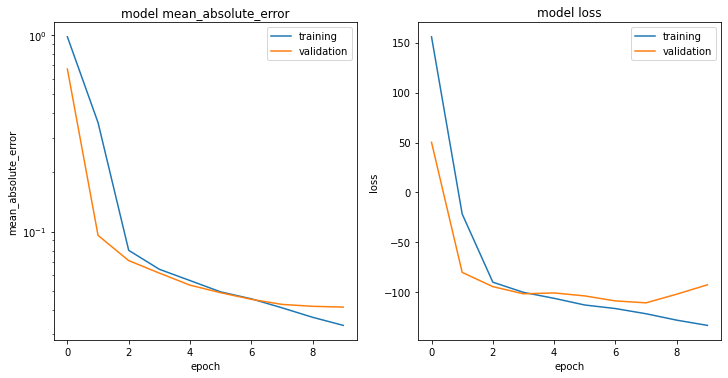

In [ ]:
def display_training_curves(training, validation, title, subplot, yscale='linear'):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])
  plt.yscale(yscale)

plt.subplots(figsize=(10,5))
plt.tight_layout()
display_training_curves(history.history['mean_absolute_error'], history.history['val_mean_absolute_error'], 'mean_absolute_error', 121, yscale='log')
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 122)

In [ ]:
# For doing custom TPU training loops

# @tf.function
# def train_step(iterator):
#   """The step function for one training step"""

#   def step_fn(inputs):
#     """The computation to run on each TPU device."""
#     images, labels = inputs
#     with tf.GradientTape() as tape:
#       logits = model(images, training=True)
#       loss = tf.keras.losses.sparse_categorical_crossentropy(
#           labels, logits, from_logits=True)
#       loss = tf.nn.compute_average_loss(loss, global_batch_size=batch_size)
#     grads = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(list(zip(grads, model.trainable_variables)))
#     training_loss.update_state(loss * strategy.num_replicas_in_sync)
#     # training_accuracy.update_state(labels, logits)

#   strategy.run(step_fn, args=(next(iterator),))

In [ ]:
import time
import pandaRL
import gym
import matplotlib.pyplot as plt 
from IPython.display import display, clear_output
import imageio
import eval

if RELATIVE_JOINTS:
  env = gym.make('pandaPlayJoints1Obj-v0')
else:
  env =  gym.make('pandaPlay-v0')
env.reset()
env.render('playback')

current_dir=/content/local_packages/pandaRL/pandaRL/envs
/content/local_packages/pandaRL/pandaRL/envs


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# model.save_weights('/content/drive/My Drive/Robotic Learning/inference_model.h5')

In [ ]:
inference_model = create_lstm_model_v2(**model_params, training=False)
inference_model.set_weights(model.get_weights())
# inference_model.load_weights('/content/drive/My Drive/Robotic Learning/inference_model.h5')

In [ ]:
f = 14 # 51
eval_data = np.load(PYBULLET_DATA_DIR+'/obs_act_etc/'+str(f)+'/data.npz')
potential_start_points = glob.glob(PYBULLET_DATA_DIR+'/states_and_ims/'+str(f)+'/env_states/*.bullet')

observations = eval_data['obs']
achieved_goals = eval_data['achieved_goals']
if RELATIVE_JOINTS:
  joints = eval_data['target_poses'] - eval_data['joint_poses'][:,:7]
  gripper = np.expand_dims(eval_data['acts'][:, -1], -1)
  actions = np.concatenate([joints,gripper], -1) 
else:
  actions = eval_data['acts']

def get_random_start_point(potential_start_points):
    idx = np.random.choice(len(potential_start_points))
    path = potential_start_points[idx]
    tstep = int(path.split("/")[-1].replace('.bullet',''))
    return path, tstep

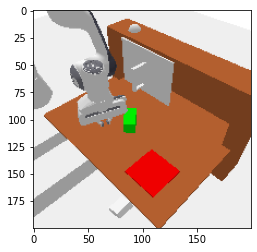

In [ ]:
# Play out action histories
f = 14 # 51
eval_data = np.load(PYBULLET_DATA_DIR+'/obs_act_etc/'+str(f)+'/data.npz')
potential_start_points = glob.glob(PYBULLET_DATA_DIR+'/states_and_ims/'+str(f)+'/env_states/*.bullet')

observations = eval_data['obs']
achieved_goals = eval_data['achieved_goals']
if RELATIVE_JOINTS:
  joints = eval_data['target_poses'] - eval_data['joint_poses'][:,:7]
  gripper = np.expand_dims(eval_data['acts'][:, -1], -1)
  actions = np.concatenate([joints,gripper], -1) 
else:
  actions = eval_data['acts']

def get_random_start_point(potential_start_points):
    idx = np.random.choice(len(potential_start_points))
    path = potential_start_points[idx]
    tstep = int(path.split("/")[-1].replace('.bullet',''))
    return path, tstep
    
path, start = get_random_start_point(potential_start_points)
env.p.restoreState(fileName=path)

vid_path = 'output/videos/trajectory.mp4'
with imageio.get_writer(vid_path, mode='I') as writer:
    for i in range(start, start+60):
        o ,r, d, _ = env.step(actions[i,:])
        writer.append_data(o['img'])
        clear_output(wait=True)
        fig = plt.imshow(o['img'])
        plt.show()
        time.sleep(0.01)

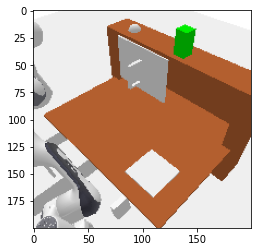

In [ ]:
# Play out stateful model predictions
path, start = get_random_start_point(potential_start_points)
env.p.restoreState(fileName=path)

vid_path = 'output/videos/trajectory.mp4'

eval_seq_len = 60
obs_in = observations[start][tf.newaxis,tf.newaxis,:]
g_in = achieved_goals[start+eval_seq_len][tf.newaxis,tf.newaxis,:] # same as two expand_dims
inference_model.reset_states()

eval_obs = []
eval_acts = []

with imageio.get_writer(vid_path, mode='I') as writer:
    for i in range(start, start+eval_seq_len):
        a = inference_model([obs_in, g_in]).sample()[0,0,:] # Reduce to 1d
        o ,r, d, _ = env.step(a)
        obs_in = o['observation'][tf.newaxis,tf.newaxis,:]
        writer.append_data(o['img'])
        clear_output(wait=True)
        fig = plt.imshow(o['img'])
        plt.show()

        eval_obs.append(o['observation'])
        eval_acts.append(a)
    inference_model.reset_states()

eval_obs = np.vstack(eval_obs)
eval_acts = np.vstack(eval_acts)

In [ ]:
eval.render_mp4(vid_path)

## Plotting Timeseries of obs, acts

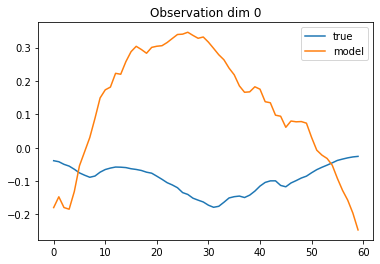

In [ ]:
#@title Visualise observations
obs_idx = 0 #@param {type:"slider", min:0, max:25, step:1}

plt.figure()
t = range(eval_seq_len)
plt.plot(t, observations[start:start+eval_seq_len,obs_idx], label='true')
plt.plot(t, eval_obs[:,obs_idx], label='model')
plt.title(f'Observation dim {obs_idx}')
plt.legend()
plt.show()

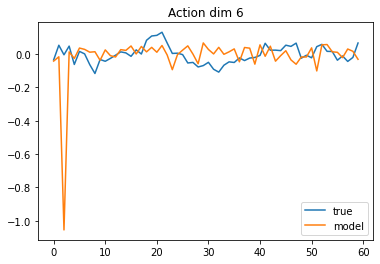

In [ ]:
#@title Visualise actions
acts_idx = 6 #@param {type:"slider", min:0, max:7, step:1}

plt.figure()
t = range(eval_seq_len)
plt.plot(t, actions[start:start+eval_seq_len,acts_idx], label='true')
plt.plot(t, eval_acts[:,acts_idx], label='model')
plt.title(f'Action dim {acts_idx}')
plt.legend()
plt.show()

# Perfect, Deterministic Reset and Replay

In [ ]:
import gym
import time
import pandaRL
if RELATIVE_JOINTS:
    env = gym.make('pandaPlayJoints-v0')
else:
    env = gym.make('pandaPlay-v0')
env.render('human')
env.reset()

In [ ]:
idx = np.random.choice(len(o))
traj_end = len(np.where(m[idx] == 1)[0])-1
#env.panda.reset_goal_pos(ag_to_dg(g[idx, traj_end,:]))
env.p.restoreState(fileName=dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')



In [ ]:
for i in range(0, traj_end+1):
    #env.p.restoreState(fileName=dataset_path+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,i]))+'.bullet')
    #time.sleep(0.1)
    env.step(a[idx, i, :])

In [ ]:
def test_subsequences(use_ori = True, replay=False):
    
    t_it = iter(tf_valid_data)
    obs, acts, goals, masks, pth, tsteps = t_it.next()
    idx = np.random.choice(len(obs))
    
    
    start_idx = str(int(tsteps[idx,0]))
    traj_end = len(np.where(masks[idx] == 1)[0])-1
    
    env.p.restoreState(fileName=dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    
    o = tf.expand_dims(obs[idx][0],0)
    
    goal = goals[idx, traj_end,:]
    #env.panda.reset_goal_pos(ag_to_dg(goal))
    goal = tf.expand_dims(goal, 0)
    
    
    if replay:
        retries = 1
    else:
        retries = 1
        
    for i in range(0,retries):
        past_state = [None, None]
        for i in range(0, traj_end+1):

            distrib, past_state = model(o, goal,  past_state = past_state)
            a = distrib.sample().numpy().squeeze() 
            
            if use_ori:
                a[3:7] =  np.array(env.panda.default_arm_orn) # because it hasn't ever had to cope with
            if replay:
                a=acts[idx, i, :] # uncomment this to replay play subsequences
            o, r, d, _ = env.step(a)
            o = tf.expand_dims(o['observation'], 0)

# MLP Evaluation

In [ ]:
def ag_to_dg(ag):
    dg = np.concatenate([ag[0:3], ag[7:10]])
    return dg

In [ ]:
# This below is only appropriate for non sequence models, which will aim for shorter timespans. 
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [ ]:

o = env.reset()
# A few representative points along the trajectory for us to test how it goes from there (before it loses coherence
# over the long trajectory)
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
# Get the init point
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
# select the goal as the end state of the trajectory 
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:# need to sample from the model if its probabilistic. 
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

# LSTM Evaluation

In [ ]:
valid = dataset[int(N_TRAJS*train_partition):]

def test_subsequences():
    
    obs, acts, goals, masks = sample_sequence_batch(valid)
    o = env.reset()
    idx = np.random.choice(len(obs))
    traj_end = len(np.where(masks[idx] == 1)[0])-1

    masks[idx][traj_end]
    start_pos = obs[idx][0][START_OBS:END_OBS].numpy()
    goal = np.expand_dims(obs[idx][traj_end][START_GOAL:END_GOAL],0)
    zero_vel = np.zeros(29)

    env.robot.reset(env, start_pos, zero_vel)
    o = np.squeeze(obs[idx][0])
    env.render()
    past_state = [None, None]
    
    for i in range(0,3):
        for i in range(0, traj_end+1):
            o = tf.expand_dims(o[START_OBS:END_OBS], 0)
            distrib, past_state = model(o, goal,  past_state = past_state)

            a = distrib.sample().numpy().squeeze() 
            #a = acts[idx, i, :] # uncomment this to replay play subsequences
            o, r, d, _ = env.step(a)
            env.render()


In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_goals, traj_init_o, traj_init_v = [valid[idx][key] for key in valid[idx].keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = tf.cast(tf.expand_dims(traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL], 0), tf.float32)
        o = tf.cast(tf.expand_dims(o[START_OBS:END_OBS],0), tf.float32)
        distrib, past_state = model(o,goal, past_state = past_state)
        
        #a = distrib.sample().numpy().squeeze() 
        a = traj_acts[t, :] # uncomment this to replay play subsequences
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)]) 

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])  

88.02201747894287 19.151499032974243


In [ ]:
import gym
import adept_envs

env = gym.make("kitchen_relax-v1")

Reading configurations for Franka
Initializing Franka sim
registering the liscence


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# MLP Evaluation

In [ ]:
# This below is only appropriate for non sequence models, which will aim for shorter timespans. 
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [ ]:

o = env.reset()
# A few representative points along the trajectory for us to test how it goes from there (before it loses coherence
# over the long trajectory)
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
# Get the init point
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
# select the goal as the end state of the trajectory 
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:# need to sample from the model if its probabilistic. 
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

# LSTM Evaluation

In [ ]:

def test_subsequences():
    obs, acts, masks = sample_sequence_batch(valid_data)
    o = env.reset()
    idx = np.random.choice(len(obs))
    traj_end = len(np.where(masks[idx] == 1)[0])-1

    masks[idx][traj_end]
    start_pos = obs[idx][0][START_OBS:END_OBS].numpy()
    goal = obs[idx][traj_end][START_GOAL:END_GOAL]
    zero_vel = np.zeros(29)

    env.robot.reset(env, start_pos, zero_vel)
    o = np.squeeze(obs[idx][0])
    env.render()


    past_state = [None, None]

    for i in range(0, traj_end+1):
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()
    

In [ ]:
for i in range(0,100):
    test_subsequences()

In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid_data)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL]
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid_data)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL]
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])  